In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import scipy

from scipy import stats
from statsmodels.stats import multitest
from statsmodels.stats.multicomp import pairwise_tukeyhsd
colormap = 'colorblind'
colors = sns.color_palette(colormap, 8)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 12, 'axes.titlesize':'medium',})

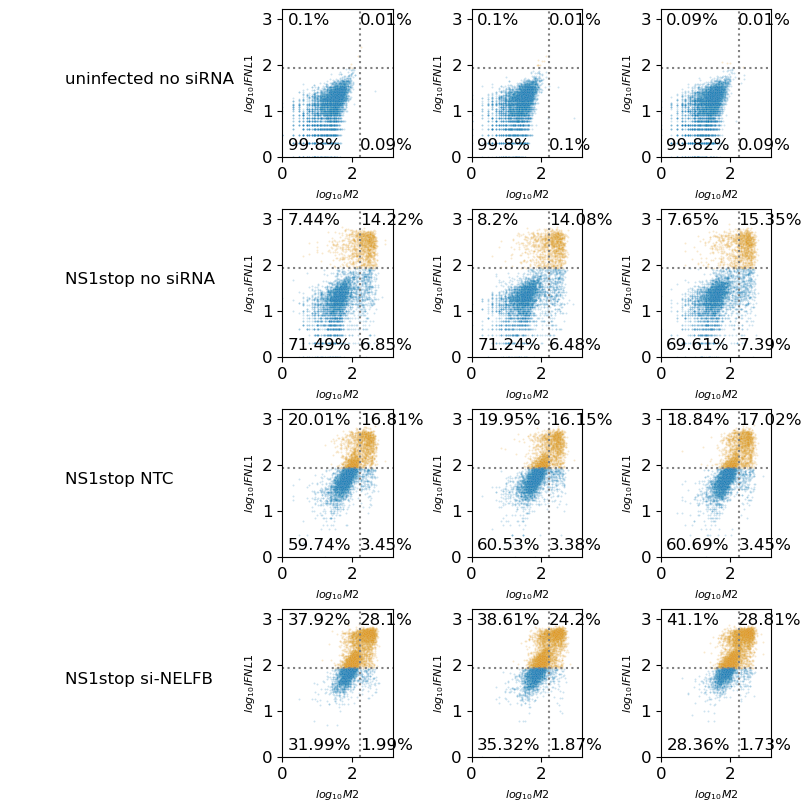

In [3]:
data = []
datafolder = "Data/"
for file in glob.glob(datafolder + '*.csv'):
    currFrame = pd.read_csv(file)

    siRNA, virus, replicate, cells = os.path.basename(file).split('_')
    currFrame['siRNA'] = siRNA
    currFrame['virus'] = virus
    currFrame['replicate'] = replicate
    data += [currFrame]  

data = pd.concat(data)
data = data.rename(columns={'FSC 488_10-A':'FSC', 'SSC 488_10-A':'SSC', 'IFNL1-A':'IFNL1', 'APC (Allophycocyanin)-A':'M2'})
data = data[['virus', 'siRNA', 'replicate', 'M2', 'IFNL1']]
Fluors = ['M2', 'IFNL1']
thresholds = {}
gateThresh = 0.999

for fluor in Fluors:
    #average value for that quantile
    threshold = data.groupby(
        ['virus', 'replicate'])[fluor].quantile(gateThresh).uninfected[['1','2','3']].mean()
    data[fluor + '_positive'] = data[fluor] > threshold
    
    #log transform but shift negatives to the right
    minVal = data[fluor].min()
    data[fluor] = np.log10(data[fluor]-minVal + 1)
    thresholds[fluor] = np.log10(threshold-minVal + 1)

colors = sns.color_palette("colorblind",2)
data['population'] = data.virus + data.siRNA
popOrder = ['uninfectedNotreatment',  'NS1stopNotreatment', 'NS1stopNTC', 'NS1stopsi1']
nameOrder = ['uninfected no siRNA', 'NS1stop no siRNA', 'NS1stop NTC', 'NS1stop si-NELFB']
replicates = ['1','2','3']
rows = len(popOrder)
columns =  len(replicates) + 1
g = plt.figure(1, (columns*2, rows*2), constrained_layout=True)
spec = g.add_gridspec(rows,columns)
currRow = -1
for name, population in enumerate(popOrder):
    currRow +=1
    currCol = 0
    ax = g.add_subplot(spec[currRow,currCol])
    ax.axis('off')
    ax.text(0.5, 0.5, nameOrder[name], transform=ax.transAxes, fontsize=12)
    currCol += 1
    for replicate in replicates:
        ax = g.add_subplot(spec[currRow,currCol])
        currFrame = data[(data['population'] == population) & (data.replicate == replicate) ]
        if len(currFrame) == 0:
            ax.axis('off')
        else:
            sampled = currFrame.sample(5000)
            sns.scatterplot(data = sampled[sampled.IFNL1_positive], x='M2', y='IFNL1', legend=False, rasterized=True, s=2,  alpha=0.2, color=colors[1])
            sns.scatterplot(data = sampled[~(sampled.IFNL1_positive)], x='M2', y='IFNL1', legend=False, rasterized=True, s=2, alpha=0.2, color=colors[0])
            plt.xlabel("$log_{10}{M2}$", fontsize=8)
            plt.ylabel("$log_{10}{IFNL1}$", fontsize=8)
            ax.axvline(x = thresholds['M2'], c=".5", ls=":")
            ax.axhline(y = thresholds['IFNL1'], c=".5", ls=":")
            ax.set_ylim(0,3.2)
            ax.set_xlim(0,3.2)
            total = len(currFrame)
            doubleNeg = len(currFrame[~(currFrame.M2_positive) & ~(currFrame.IFNL1_positive)])
            singPosY = len(currFrame[~(currFrame.M2_positive) & (currFrame.IFNL1_positive)])
            singPosX = len(currFrame[(currFrame.M2_positive) & ~(currFrame.IFNL1_positive)])
            doubPos = len(currFrame[(currFrame.M2_positive) & (currFrame.IFNL1_positive)])
            ax.text(0.05, 0.05, str(round(doubleNeg/total * 100, 2)) + '%', transform=ax.transAxes)
            ax.text(0.05, 0.9, str(round(singPosY/total * 100, 2)) + '%', transform=ax.transAxes)
            ax.text(0.7, 0.05, str(round(singPosX/total * 100,2)) + '%', transform=ax.transAxes)
            ax.text(0.7, 0.9, str(round(doubPos/total * 100,2)) + '%', transform=ax.transAxes)   
        currCol+=1

plt.savefig('Figures/IFNL1M2_stained_dist.pdf', format='pdf', bbox_inches = "tight")

In [ ]:
graphNS1 = data[(data.virus == 'NS1stop') & (data.siRNA != 'Notreatment')].reset_index()
graphNS1 = graphNS1.drop(['virus','population'],axis=1)
order = ['NTC', 'si1']
nameOrder = ['Non-targeting', 'NELFB']

replicates = ['1', '2', '3']
rows = 1
columns = len(replicates) + 1
g = plt.figure(1, (columns*2, rows*2), constrained_layout=True)
spec = g.add_gridspec(rows,columns)
currRow = -1

currRow = 0
currCol = 0
ax = g.add_subplot(spec[currRow,currCol])
ax.axis('off')
currCol += 1
for replicate in replicates:
    ax = g.add_subplot(spec[currRow,currCol])
    currFrame = graphNS1[(graphNS1.replicate == replicate)]
    if len(currFrame) == 0:
        ax.axis('off')
    else:
        sns.kdeplot(data=currFrame, x="M2", hue = 'siRNA', ax=ax, hue_order = order, palette = sns.color_palette("colorblind",2), fill = True, alpha = 0.1, common_norm=False)
        plt.xlabel("$log_{10}{M2}$", fontsize=8)
        plt.ylabel("Population Density", fontsize=8)
        ax.set_xlim(0,3)
        
        ax.set_ylim(0,2)
            
        if ~((name == 0) & (replicate == replicates[len(replicates) - 2])):
            currCol+=1

plt.savefig('Figures/M2dist.pdf', format='pdf', bbox_inches = "tight")

In [ ]:
ax=sns.stripplot(x='siRNA', y='M2', data=graphNS1,  edgecolor='black', order = order, color = ['0.5'],
            jitter=True, dodge=True, linewidth=1, s=9, alpha = 0.3)

sns.despine()
plt.xlabel('siRNA')
plt.ylabel('$log_{10}{M2}$ MFI')
plt.xticks(np.arange(0,2,1), nameOrder, rotation=45, ha='right')
plt.ylim(1.8,2.2)
plt.yticks(np.arange(1.8,2.2,0.1))

#stats for effect of siRNA
tstat, pval = stats.ttest_ind(graphNS1[graphNS1.siRNA == 'NTC'].M2, graphNS1[graphNS1.siRNA == 'si1'].M2)
print(pval)

y = graphNS1[graphNS1.siRNA == 'NTC'].M2.mean()
position = 0
plt.plot([position-0.2, position+0.2], [y, y], lw=2, c='k', zorder=9)
y = graphNS1[graphNS1.siRNA == 'si1'].M2.mean()
position = 1
plt.plot([position-0.2, position+0.2], [y, y], lw=2, c='k', zorder=9)


plt.savefig('Figures/M2_MFI.pdf', format='pdf', bbox_inches = "tight")

,siRNA,replicate,M2,IFNL1,M2_positive,IFNL1_positive
0,NTC,1,1.962286,1.869033,20.255603,36.818734
1,NTC,2,1.951145,1.863749,19.525866,36.096675
2,NTC,3,1.988734,1.858539,20.472481,35.853659
3,si1,1,2.099487,2.130569,30.089980,66.024395
4,si1,2,2.056107,2.102113,26.071033,62.810076
5,si1,3,2.097839,2.159896,30.547836,69.909072


0.0001326195550808158


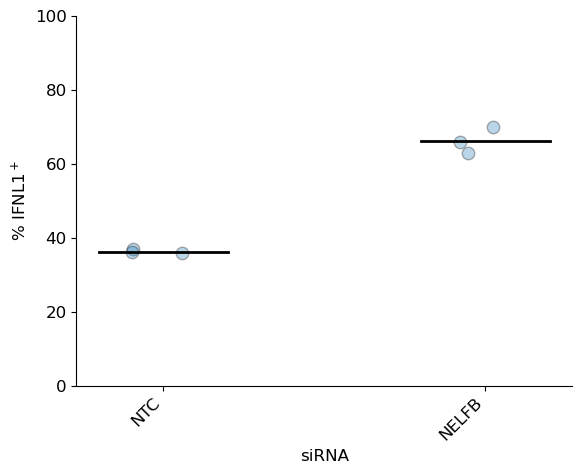

In [6]:
graphNS1 = data[(data.virus == 'NS1stop') & (data.siRNA != 'Notreatment')]
graphNS1 = graphNS1.drop(['virus','population'],axis=1)
graphNS1 = graphNS1.groupby(['siRNA','replicate']).mean().reset_index()
graphNS1['IFNL1_positive'] = graphNS1.IFNL1_positive * 100
graphNS1['M2_positive'] = graphNS1.M2_positive * 100
order = ['NTC', 'si1']
nameOrder = ['NTC', 'NELFB']
display(graphNS1)

ax=sns.stripplot(x='siRNA', y='IFNL1_positive', data=graphNS1,  edgecolor='black', order = order,
            jitter=True, dodge=True, linewidth=1, s=9, alpha = 0.3)

sns.despine()
plt.ylim(0,100)
plt.xlabel('siRNA')
plt.ylabel('% IFNL1$^+$')
plt.xticks(np.arange(0,2,1), nameOrder, rotation=45, ha='right')

#stats for effect of siRNA
tstat, pval = stats.ttest_ind(graphNS1[graphNS1.siRNA == 'NTC'].IFNL1_positive, graphNS1[graphNS1.siRNA == 'si1'].IFNL1_positive)
print(pval)

y = graphNS1[graphNS1.siRNA == 'NTC'].IFNL1_positive.mean()
position = 0
plt.plot([position-0.2, position+0.2], [y, y], lw=2, c='k', zorder=9)
y = graphNS1[graphNS1.siRNA == 'si1'].IFNL1_positive.mean()
position = 1
plt.plot([position-0.2, position+0.2], [y, y], lw=2, c='k', zorder=9)

plt.savefig('Figures/IFNL1positive.pdf', format='pdf', bbox_inches = "tight")

,siRNA,replicate,M2,IFNL1,M2_positive,IFNL1_positive
0,NTC,1,2.226063,2.282151,45.655874,100.0
1,NTC,2,2.218920,2.275680,44.735719,100.0
2,NTC,3,2.244698,2.281556,47.465897,100.0
3,si1,1,2.217195,2.339670,42.561138,100.0
4,si1,2,2.186229,2.331240,38.524861,100.0
5,si1,3,2.204844,2.343383,41.216187,100.0


0.0001480711612013378


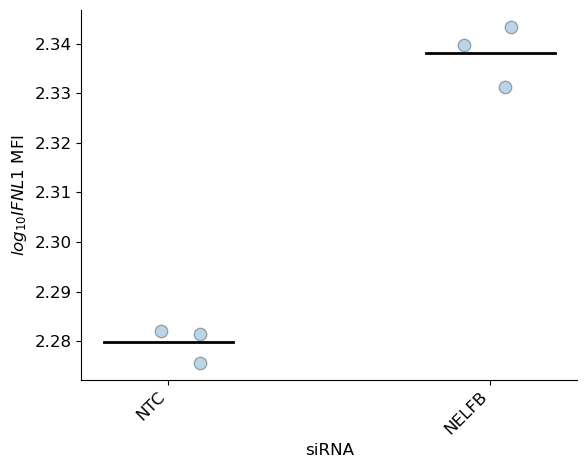

In [4]:
graphNS1 = data[(data.virus == 'NS1stop') & (data.siRNA != 'Notreatment')]
graphNS1 = graphNS1.drop(['virus','population'],axis=1)
graphNS1_IFN = graphNS1[graphNS1['IFNL1_positive']]
graphNS1_IFN = graphNS1_IFN.groupby(['siRNA','replicate']).mean().reset_index()
graphNS1_IFN['IFNL1_positive'] = graphNS1_IFN.IFNL1_positive * 100
graphNS1_IFN['M2_positive'] = graphNS1_IFN.M2_positive * 100
order = ['NTC', 'si1']
nameOrder = ['NTC', 'NELFB']
display(graphNS1_IFN)

ax=sns.stripplot(x='siRNA', y='IFNL1', data=graphNS1_IFN,  edgecolor='black', order = order,
            jitter=True, dodge=True, linewidth=1, s=9, alpha = 0.3)

sns.despine()
plt.xlabel('siRNA')
plt.ylabel('$log_{10}{IFNL1}$ MFI')
plt.xticks(np.arange(0,2,1), nameOrder, rotation=45, ha='right')
plt.ylim(2.2,2.4)

#stats for effect of siRNA
tstat, pval = stats.ttest_ind(graphNS1_IFN[graphNS1_IFN.siRNA == 'NTC'].IFNL1, graphNS1_IFN[graphNS1_IFN.siRNA == 'si1'].IFNL1)
print(pval)

y = graphNS1_IFN[graphNS1_IFN.siRNA == 'NTC'].IFNL1.mean()
position = 0
plt.plot([position-0.2, position+0.2], [y, y], lw=2, c='k', zorder=9)
y = graphNS1_IFN[graphNS1_IFN.siRNA == 'si1'].IFNL1.mean()
position = 1
plt.plot([position-0.2, position+0.2], [y, y], lw=2, c='k', zorder=9)


plt.savefig('Figures/IFNL1pos_MFI.pdf', format='pdf', bbox_inches = "tight")

,siRNA,replicate,M2,IFNL1,M2_positive,IFNL1_positive
0,si1,2,2.348305,2.707570,True,True
1,si1,2,1.799341,1.812913,False,False
2,si1,2,1.995635,2.149219,False,True
3,si1,2,2.657056,1.623249,True,False
4,si1,2,1.662758,1.716003,False,False
...,...,...,...,...,...,...
128134,si1,1,2.139879,2.689309,False,True
128135,si1,1,2.158362,2.642465,False,True
128136,si1,1,2.956649,2.551450,True,True
128137,si1,1,1.414973,1.924279,False,True


,siRNA,replicate,expression_bin,M2,IFNL1,M2_positive,IFNL1_positive
0,NTC,1,1.0,4809,4809,4809,4809
1,NTC,1,2.0,6902,6902,6902,6902
2,NTC,1,3.0,9089,9089,9089,9089
3,NTC,1,4.0,12034,12034,12034,12034
4,NTC,1,5.0,12675,12675,12675,12675
...,...,...,...,...,...,...,...
91,si1,3,12.0,6197,6197,6197,6197
92,si1,3,13.0,6786,6786,6786,6786
93,si1,3,14.0,7187,7187,7187,7187
94,si1,3,15.0,7182,7182,7182,7182


,siRNA,replicate,expression_bin,M2,IFNL1,M2_positive,IFNL1_positive
0,NTC,1,1.0,1.613116,1.525445,0.0,3.763776
1,NTC,1,2.0,1.682163,1.570487,0.0,4.187192
2,NTC,1,3.0,1.751211,1.626229,0.0,6.018264
3,NTC,1,4.0,1.820259,1.686769,0.0,8.841615
4,NTC,1,5.0,1.889307,1.754723,0.0,14.193294
...,...,...,...,...,...,...,...
91,si1,3,12.0,2.372640,2.462964,1.0,93.884137
92,si1,3,13.0,2.441688,2.493239,1.0,93.840259
93,si1,3,14.0,2.510736,2.522216,1.0,94.893558
94,si1,3,15.0,2.579784,2.544577,1.0,95.544417


,siRNA,replicate,expression_bin,M2_x,IFNL1_x,M2_positive_x,IFNL1_positive_x,M2_y,IFNL1_y,M2_positive_y,IFNL1_positive_y
0,NTC,1,1.0,1.613116,1.525445,0.0,3.763776,4809,4809,4809,4809
1,NTC,1,2.0,1.682163,1.570487,0.0,4.187192,6902,6902,6902,6902
2,NTC,1,3.0,1.751211,1.626229,0.0,6.018264,9089,9089,9089,9089
3,NTC,1,4.0,1.820259,1.686769,0.0,8.841615,12034,12034,12034,12034
4,NTC,1,5.0,1.889307,1.754723,0.0,14.193294,12675,12675,12675,12675
...,...,...,...,...,...,...,...,...,...,...,...
91,si1,3,12.0,2.372640,2.462964,1.0,93.884137,6197,6197,6197,6197
92,si1,3,13.0,2.441688,2.493239,1.0,93.840259,6786,6786,6786,6786
93,si1,3,14.0,2.510736,2.522216,1.0,94.893558,7187,7187,7187,7187
94,si1,3,15.0,2.579784,2.544577,1.0,95.544417,7182,7182,7182,7182


/tmp/ipykernel_3732553/2745097999.py:30: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(data=graph, x="M2_x", y="IFNL1_positive_x", palette = sns.color_palette("colorblind"), hue = 'siRNA', hue_order=['NTC','si1'],


0.0005909807250643864
0.0007294764299536678
0.0009031015064132009
0.0006666470182537376
0.000624176110603376
0.00042529526513562213
0.0010121140619254877
0.003832852750432515
0.0030751726610559397
0.00030471231458417187
0.00021288020935697537
0.00017557560977411778
8.648766934148822e-06
2.2292505134314686e-05
6.384449520293266e-05
0.0001393951082068793
(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True]), array([0.00096967, 0.00097264, 0.00111151, 0.00096967, 0.00096967,
       0.00085059, 0.0011567 , 0.00383285, 0.00328018, 0.00069649,
       0.00056768, 0.00056184, 0.00013838, 0.00017834, 0.0003405 ,
       0.00055758]), 0.0032006977101884937, 0.003125)


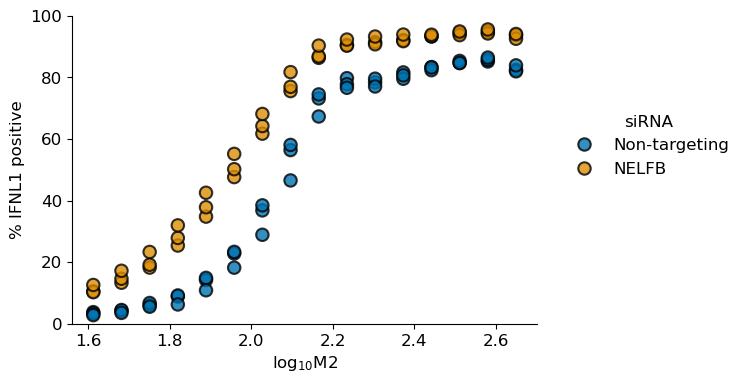

In [19]:
graph = data[(data.virus == 'NS1stop') & (data.siRNA != 'Notreatment')]
graph = graph.drop(['virus','population'],axis=1)
fig,ax = plt.subplots(figsize=(6,4))
display(graph)

#quantiles
#divide whole range into 16ths from 5th to 95th percentile
maxVal = graph.M2.quantile(0.95)
minVal = graph.M2.quantile(0.05)
steps = (maxVal - minVal)/15

graph = graph[graph['M2'] > minVal]
graph['expression_bin'] =  ((graph.M2-minVal)/steps).apply(np.ceil) 
#set top bin to the maxVal
graph.loc[graph.expression_bin > 16, 'expression_bin'] = 16

#remove bins with less than 100 observations
bincounts = graph.groupby(['siRNA', 'replicate', 'expression_bin']).count().reset_index()
bins = bincounts[bincounts['M2_positive'] > 100]
display(bins)

graph = graph.groupby(['siRNA', 'replicate', 'expression_bin']).mean().reset_index()
graph['M2'] = graph.expression_bin * steps + minVal
graph['IFNL1_positive'] = graph.IFNL1_positive * 100
display(graph)

graph = graph.merge(bins, on=['siRNA', 'replicate', 'expression_bin'])
display(graph)

sns.scatterplot(data=graph, x="M2_x", y="IFNL1_positive_x", palette = sns.color_palette("colorblind"), 
                hue = 'siRNA', hue_order=['NTC','si1'],       
                edgecolor='0', linewidth=1.5, s=80, ax=ax, alpha=0.8)
plt.ylim(0,100)

sns.despine()

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:2], ['Non-targeting','NELFB'], bbox_to_anchor=(1.05, 0.7), loc=2, borderaxespad=0.,frameon=False, title='siRNA')

plt.xlabel('log$_{10}$M2')
plt.ylabel('% IFNL1 positive')

pvals = []
for position, b in enumerate(range(1,17)):
    curr = graph[graph.expression_bin == b]
    tstat, pval = stats.ttest_ind(curr[curr.siRNA == 'si1'].IFNL1_positive_x, curr[curr.siRNA == 'NTC'].IFNL1_positive_x)
    print(pval)
    pvals += [pval]
pvals = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
print(pvals)

plt.savefig('Figures/probIFNpositivityFlowsiRNA.pdf', format='pdf', bbox_inches = "tight")